### aim: 

### date: 

In [39]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [40]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [41]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 13})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 13}
plt.rcParams['text.usetex'] = True
plt.rc('font', **font)

import coldic as cd
reload(cd)



<module 'coldic' from '/gpfs/scratch/mep22dku/windEval/plottingCode/coldic.py'>

## dictionary of colors for attribution

In [42]:
m3dict = {
    '1A': {'name': 'EM1','color':'darkgray','linestyle' : '-','linewidth' : 1, 'sam': '',},
    '1AM2': {'name': 'EM2','color':'darkgray','linestyle' : ':','linewidth' : 1,'sam': '',},
    '1AM3': {'name': 'EM3','color':'darkgray','linestyle' : '--','linewidth' : 1,'sam': '',},
    '1AEM': {'name': 'SSP 1-2.6 \n HIST. OZONE','color':'darkgray','linestyle' : '-','linewidth' : 2.5,'sam': '',},

    '1B': {'name': 'EM1','color':'black','linestyle' : '-','linewidth' : 1,'sam': 'UKESMm1',},
    '1BM2': {'name': 'EM2','color':'black','linestyle' : ':','linewidth' : 1,'sam': 'UKESMm2',},
    '1BM3': {'name': 'EM3','color':'black','linestyle' : '--','linewidth' : 1,'sam': 'UKESMm3',},
    '1BEM': {'name': 'SSP 3-7.0 \n HIST. OZONE','color':'black','linestyle' : '-','linewidth' : 2.5,'sam': 'UKESMEM',},
    
    '2A': {'name': 'EM1','color':'mediumaquamarine','linestyle' : '-','linewidth' : 1,'sam': '',},
    '2AM2': {'name': 'EM2','color':'mediumaquamarine','linestyle' : ':','linewidth' : 1,'sam': '',},
    '2AM3': {'name': 'EM3','color':'mediumaquamarine','linestyle' : '--','linewidth' : 1,'sam': '',},
    '2AEM': {'name': 'SSP 1-2.6 \n NO HOLE','color':'mediumaquamarine','linestyle' : '-','linewidth' : 2.5,'sam': '',},

    '2B': {'name': '','color':'forestgreen','linestyle' : '-','linewidth' : 1,'sam': 'UKESM-NOm1',},
    '2BM2': {'name': '','color':'forestgreen','linestyle' : ':','linewidth' : 1,'sam': 'UKESM-NOm2',},
    '2BM3': {'name': '','color':'forestgreen','linestyle' : '--','linewidth' : 1,'sam': 'UKESM-NOm3',},
    '2BEM': {'name': 'SSP 3-7.0 \n NO HOLE','color':'forestgreen','linestyle' : '-','linewidth' : 2.5,'sam': 'UKESMEM-NO',},  
    
    'ERA5': {'name': 'ERA5','color':'#6db8ff','linestyle' : '-','linewidth' : 2.5,'sam': 'ERA5',},  

}

## plot ts of sam index and wind, yearly, DJF

Text(0.5, 1.0, 'summer sam index')

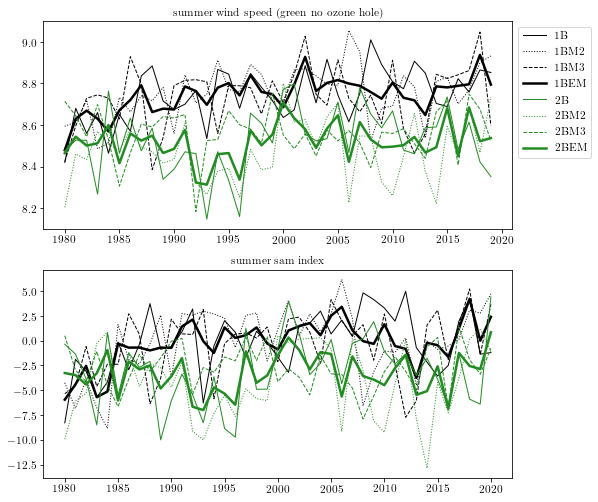

In [43]:
sdir = '/gpfs/data/greenocean2/software/products/windsFromComponents/dailyStandard/intProc/'

fact = 0.7
fig, axs = plt.subplots(2,1, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()


scens = ['1B','1BM2','1BM3','1BEM',\
        '2B','2BM2','2BM3','2BEM',]

for scen in scens:
    td = xr.open_dataset(f'{sdir}/scen{scen}_UKESM_40-60S_mean_wspd_ts_1950-2099.nc')
    tp = td.sel(time_counter=(td['time_counter.season'] == 'DJF')).resample(time_counter='Y').mean()
    time_ar = tp.time_counter.values
    years = [dt.year for dt in time_ar]
    axs[0].plot(years[30:70], tp.wspd10m[30:70], color = m3dict[scen]['color'], linewidth = m3dict[scen]['linewidth'],\
    linestyle = m3dict[scen]['linestyle'],
    label = scen)
    
    prod = m3dict[scen]['sam']
    td = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/{prod}/SAM.nc')
    tp = td.sel(time=(td['time.season'] == 'DJF')).resample(time='Y').mean()
    time_ar = tp.time.values
    years = time_ar.astype('datetime64[Y]').astype(int) + 1970
    #years = [dt.year for dt in time_ar]
    axs[1].plot(years, tp.SAM, color = m3dict[scen]['color'], linewidth = m3dict[scen]['linewidth'],\
    linestyle = m3dict[scen]['linestyle'],
    label = scen)
    
axs[0].legend(bbox_to_anchor = [1,1])

axs[0].set_title('summer wind speed (green no ozone hole)')
axs[1].set_title('summer sam index')

## trend calculation for ukesm 3em and mean

In [44]:
import pymannkendall as mk
from scipy import stats

def give_trends(ts_y):

    ts_x = np.arange(0,len(ts_y))
    trend, h, mk_p, z, Tau, s, var_s, mk_slope, intercept = mk.original_test(ts_y)
    lin_slope, intercept, r_value, lin_p, std_err = stats.linregress(ts_x,ts_y)
    
    return mk_slope, mk_p, lin_slope, lin_p


In [45]:
ex = False

if ex:
    scens = ['1B','1BM2','1BM3','1BEM','2B','2BM2','2BM3','2BEM']

    data = np.zeros([3,len(scens)])
    data2 = np.zeros([3,len(scens)])
    df = pd.DataFrame(data, columns=scens, index  = ['FY','DJF','JJA'])
    df2 = pd.DataFrame(data2, columns=scens, index  = ['FY','DJF','JJA'])

    for scen in scens:

        td = xr.open_dataset(f'{sdir}/scen{scen}_UKESM_40-60S_mean_wspd_ts_1950-2099.nc')
        t = td.wspd10m.sel(time_counter=(td['time_counter.season'] == 'DJF')).\
            groupby('time_counter.year').mean().sel(year = slice(1980, 1999)).values 
        mk_slope, mk_p, lin_slope, lin_p = give_trends(t)
        df.loc['DJF',scen] = lin_slope*10
        print(lin_p)
        if (lin_p < 0.05):
            print('smol')
            df2.loc['DJF',scen] = lin_slope*10

        td = xr.open_dataset(f'{sdir}/scen{scen}_UKESM_40-60S_mean_wspd_ts_1950-2099.nc')
        t = td.wspd10m.sel(time_counter=(td['time_counter.season'] == 'JJA')).\
            groupby('time_counter.year').mean().sel(year = slice(1980, 1999)).values 
        mk_slope, mk_p, lin_slope, lin_p = give_trends(t)
        print(lin_p)
        df.loc['JJA',scen] = lin_slope*10
        if (lin_p < 0.05):
            print('smol')
            df2.loc['JJA',scen] = lin_slope*10

        td = xr.open_dataset(f'{sdir}/scen{scen}_UKESM_40-60S_mean_wspd_ts_1950-2099.nc')
        t = td.wspd10m.\
            groupby('time_counter.year').mean().sel(year = slice(1980, 1999)).values 
        mk_slope, mk_p, lin_slope, lin_p = give_trends(t)
        df.loc['FY',scen] = lin_slope*10
        print(lin_p)

        if (lin_p < 0.05):
            print('smol')
            df2.loc['FY',scen] = lin_slope*10

    df.to_csv(f'./plts/UKESM-trend_wspd-1980-1999.csv')
    df2.to_csv(f'./plts/UKESM-trendsig_wspd-1980-1999.csv')

    data = np.zeros([3,len(scens)])
    data2 = np.zeros([3,len(scens)])
    df = pd.DataFrame(data, columns=scens, index  = ['FY','DJF','JJA'])
    df2 = pd.DataFrame(data2, columns=scens, index  = ['FY','DJF','JJA'])

    for scen in scens:

        td = xr.open_dataset(f'{sdir}/scen{scen}_UKESM_40-60S_mean_wspd_ts_1950-2099.nc')
        t = td.wspd10m.sel(time_counter=(td['time_counter.season'] == 'DJF')).\
            groupby('time_counter.year').mean().sel(year = slice(1980, 2019)).values 
        mk_slope, mk_p, lin_slope, lin_p = give_trends(t)
        df.loc['DJF',scen] = lin_slope*10
        print(lin_p)
        if (lin_p < 0.05):
            print('smol')
            df2.loc['DJF',scen] = lin_slope*10

        td = xr.open_dataset(f'{sdir}/scen{scen}_UKESM_40-60S_mean_wspd_ts_1950-2099.nc')
        t = td.wspd10m.sel(time_counter=(td['time_counter.season'] == 'JJA')).\
            groupby('time_counter.year').mean().sel(year = slice(1980, 2019)).values 
        mk_slope, mk_p, lin_slope, lin_p = give_trends(t)
        print(lin_p)
        df.loc['JJA',scen] = lin_slope*10
        if (lin_p < 0.05):
            print('smol')
            df2.loc['JJA',scen] = lin_slope*10

        td = xr.open_dataset(f'{sdir}/scen{scen}_UKESM_40-60S_mean_wspd_ts_1950-2099.nc')
        t = td.wspd10m.\
            groupby('time_counter.year').mean().sel(year = slice(1980, 2019)).values 
        mk_slope, mk_p, lin_slope, lin_p = give_trends(t)
        df.loc['FY',scen] = lin_slope*10
        print(lin_p)

        if (lin_p < 0.05):
            print('smol')
            df2.loc['FY',scen] = lin_slope*10

    df.to_csv(f'./plts/UKESM-trend_wspd-1980-2019.csv')
    df2.to_csv(f'./plts/UKESM-trendsig_wspd-1980-2019.csv')



## do the same but for ERA5

In [46]:
if ex:
    
    scens = ['ERA5']
    data = np.zeros([3,len(scens)])
    data2 = np.zeros([3,len(scens)])
    df = pd.DataFrame(data, columns=scens, index  = ['FY','DJF','JJA'])
    df2 = pd.DataFrame(data2, columns=scens, index  = ['FY','DJF','JJA'])

    for scen in scens:

        td = xr.open_dataset(f'{sdir}/ERA5_40-60S_mean_wspd_ts_1980-2019.nc')
        t = td.wspd10m.sel(time_counter=(td['time_counter.season'] == 'DJF')).\
            groupby('time_counter.year').mean().sel(year = slice(1980, 1999)).values 
        mk_slope, mk_p, lin_slope, lin_p = give_trends(t)
        df.loc['DJF',scen] = lin_slope*10
        print(lin_p)
        if (lin_p < 0.05):
            print('smol')
            df2.loc['DJF',scen] = lin_slope*10

        td = xr.open_dataset(f'{sdir}/ERA5_40-60S_mean_wspd_ts_1980-2019.nc')
        t = td.wspd10m.sel(time_counter=(td['time_counter.season'] == 'JJA')).\
            groupby('time_counter.year').mean().sel(year = slice(1980, 1999)).values 
        mk_slope, mk_p, lin_slope, lin_p = give_trends(t)
        print(lin_p)
        df.loc['JJA',scen] = lin_slope*10
        if (lin_p < 0.05):
            print('smol')
            df2.loc['JJA',scen] = lin_slope*10

        td = xr.open_dataset(f'{sdir}/ERA5_40-60S_mean_wspd_ts_1980-2019.nc')
        t = td.wspd10m.\
            groupby('time_counter.year').mean().sel(year = slice(1980, 1999)).values 
        mk_slope, mk_p, lin_slope, lin_p = give_trends(t)
        df.loc['FY',scen] = lin_slope*10
        print(lin_p)

        if (lin_p < 0.05):
            print('smol')
            df2.loc['FY',scen] = lin_slope*10

    df.to_csv(f'./plts/ERA5-trend_wspd-1980-1999.csv')
    df2.to_csv(f'./plts/ERA5-trendsig_wspd-1980-1999.csv')

    data = np.zeros([3,len(scens)])
    data2 = np.zeros([3,len(scens)])
    df = pd.DataFrame(data, columns=scens, index  = ['FY','DJF','JJA'])
    df2 = pd.DataFrame(data2, columns=scens, index  = ['FY','DJF','JJA'])

    for scen in scens:

        td = xr.open_dataset(f'{sdir}/ERA5_40-60S_mean_wspd_ts_1980-2019.nc')
        t = td.wspd10m.sel(time_counter=(td['time_counter.season'] == 'DJF')).\
            groupby('time_counter.year').mean().sel(year = slice(1980, 2019)).values 
        mk_slope, mk_p, lin_slope, lin_p = give_trends(t)
        df.loc['DJF',scen] = lin_slope*10
        print(lin_p)
        if (lin_p < 0.05):
            print('smol')
            df2.loc['DJF',scen] = lin_slope*10

        td = xr.open_dataset(f'{sdir}/ERA5_40-60S_mean_wspd_ts_1980-2019.nc')
        t = td.wspd10m.sel(time_counter=(td['time_counter.season'] == 'JJA')).\
            groupby('time_counter.year').mean().sel(year = slice(1980, 2019)).values 
        mk_slope, mk_p, lin_slope, lin_p = give_trends(t)
        print(lin_p)
        df.loc['JJA',scen] = lin_slope*10
        if (lin_p < 0.05):
            print('smol')
            df2.loc['JJA',scen] = lin_slope*10

        td = xr.open_dataset(f'{sdir}/ERA5_40-60S_mean_wspd_ts_1980-2019.nc')
        t = td.wspd10m.\
            groupby('time_counter.year').mean().sel(year = slice(1980, 2019)).values 
        mk_slope, mk_p, lin_slope, lin_p = give_trends(t)
        df.loc['FY',scen] = lin_slope*10
        print(lin_p)

        if (lin_p < 0.05):
            print('smol')
            df2.loc['FY',scen] = lin_slope*10

    df.to_csv(f'./plts/ERA5-trend_wspd-1980-2019.csv')
    df2.to_csv(f'./plts/ERA5-trendsig_wspd-1980-2019.csv')


## open trends in winds for ukesm and era5

In [47]:
UK_wind_trend = pd.read_csv(f'./plts/UKESM-trend_wspd-1980-2019.csv', index_col=0)
ERA_wind_trend = pd.read_csv(f'./plts/ERA5-trend_wspd-1980-2019.csv', index_col=0)
wind_trend = pd.concat([UK_wind_trend, ERA_wind_trend], axis=1)

UK_wind_trend80 = pd.read_csv(f'./plts/UKESM-trend_wspd-1980-1999.csv', index_col=0)
ERA_wind_trend80 = pd.read_csv(f'./plts/ERA5-trend_wspd-1980-1999.csv', index_col=0)
wind_trend80 = pd.concat([UK_wind_trend80, ERA_wind_trend80], axis=1)

UK_wind_trendsig = pd.read_csv(f'./plts/UKESM-trendsig_wspd-1980-2019.csv', index_col=0)
ERA_wind_trendsig = pd.read_csv(f'./plts/ERA5-trendsig_wspd-1980-2019.csv', index_col=0)
wind_trendsig = pd.concat([UK_wind_trendsig, ERA_wind_trendsig], axis=1)

UK_wind_trendsig80 = pd.read_csv(f'./plts/UKESM-trendsig_wspd-1980-1999.csv', index_col=0)
ERA_wind_trendsig80 = pd.read_csv(f'./plts/ERA5-trendsig_wspd-1980-1999.csv', index_col=0)
wind_trendsig80 = pd.concat([UK_wind_trendsig80, ERA_wind_trendsig80], axis=1)

In [48]:
# wind_trendsig80.rename(columns={'1B': '1BM1', '2B': '2BM1'})
# wind_trend80.rename(columns={'1B': '1BM1', '2B': '2BM1'})#,#,

# reformat tables of trends in the sam, in ukesm (trends in ERA5 and obs calculated already in Fig-SAM)

In [49]:
SAM_trend80 = pd.read_csv(f'./plts/SAM_trend-1980-1999.csv', index_col=0)
SAM_trend = pd.read_csv(f'./plts/SAM_trend-1980-2019.csv', index_col=0)


SAM_trend80 = SAM_trend80.drop(columns=['NCEP-NCAR', 'MERRA', 'JRA3Q',])
SAM_trend = SAM_trend.drop(columns=['NCEP-NCAR', 'MERRA', 'JRA3Q',])

SAM_trend.rename(columns={'UKESMEM': '1BEM',\
                                      'UKESMm1': '1B',\
                                     'UKESMm2': '1BM2',\
                                     'UKESMm3': '1BM3',
                                     'UKESMEM-NO': '2BEM',\
                                      'UKESM-NOm1': '2B',\
                                     'UKESM-NOm2': '2BM2',\
                                     'UKESM-NOm3': '2BM3',}, inplace=True)

SAM_trend80.rename(columns={'UKESMEM': '1BEM',\
                                      'UKESMm1': '1B',\
                                     'UKESMm2': '1BM2',\
                                     'UKESMm3': '1BM3',
                                     'UKESMEM-NO': '2BEM',\
                                      'UKESM-NOm1': '2B',\
                                     'UKESM-NOm2': '2BM2',\
                                     'UKESM-NOm3': '2BM3',}, inplace=True)

SAM_trend80 = SAM_trend80.drop(index=['MAM', 'SON'])
SAM_trend = SAM_trend.drop(index=['MAM', 'SON'])

SAM_trend = SAM_trend.rename(index={'full year': 'FY'}, )
SAM_trend80 = SAM_trend80.rename(index={'full year': 'FY'})


In [50]:
SAM_atrendsig80 = pd.read_csv(f'./plts/SAM_trendsig-1980-1999.csv', index_col=0)
SAM_atrendsig = pd.read_csv(f'./plts/SAM_trendsig-1980-2019.csv', index_col=0)


SAM_atrendsig80 = SAM_atrendsig80.drop(columns=['NCEP-NCAR', 'MERRA', 'JRA3Q',])
SAM_atrendsig = SAM_atrendsig.drop(columns=['NCEP-NCAR', 'MERRA', 'JRA3Q',])

SAM_atrendsig = SAM_atrendsig.rename(index={'full year': 'FY'}, )
SAM_atrendsig80 = SAM_atrendsig80.rename(index={'full year': 'FY'})


SAM_atrendsig.rename(columns={'UKESMEM': '1BEM',\
                                      'UKESMm1': '1B',\
                                     'UKESMm2': '1BM2',\
                                     'UKESMm3': '1BM3',
                                     'UKESMEM-NO': '2BEM',\
                                      'UKESM-NOm1': '2B',\
                                     'UKESM-NOm2': '2BM2',\
                                     'UKESM-NOm3': '2BM3',}, inplace=True)

SAM_atrendsig80.rename(columns={'UKESMEM': '1BEM',\
                                      'UKESMm1': '1B',\
                                     'UKESMm2': '1BM2',\
                                     'UKESMm3': '1BM3',
                                     'UKESMEM-NO': '2BEM',\
                                      'UKESM-NOm1': '2B',\
                                     'UKESM-NOm2': '2BM2',\
                                     'UKESM-NOm3': '2BM3',}, inplace=True)

SAM_atrendsig80 = SAM_atrendsig80.drop(index=['MAM', 'SON'])
SAM_atrendsig = SAM_atrendsig.drop(index=['MAM', 'SON'])


SAM_trendsig = SAM_trend.mask(SAM_atrendsig > 0.05, 0)
SAM_trendsig80 = SAM_trend80.mask(SAM_atrendsig80 > 0.05, 0)



## figure itself, this is dumb

In [51]:
print(SAM_trendsig)
print(SAM_trend)

print(wind_trendsig)
print(wind_trend)

         ERA5      1BEM        1B      1BM2  1BM3  2BEM        2B  2BM2  2BM3  \
FY   0.598824  0.592871  0.749745  0.723096   0.0   0.0  0.587004   0.0   0.0   
DJF  0.919548  0.931833  1.157021  0.921504   0.0   0.0  0.000000   0.0   0.0   
JJA  0.000000  0.000000  0.000000  0.000000   0.0   0.0  0.000000   0.0   0.0   

          obs  
FY   0.547384  
DJF  1.001601  
JJA  0.000000  
         ERA5      1BEM        1B      1BM2      1BM3      2BEM        2B  \
FY   0.598824  0.592871  0.749745  0.723096  0.306272  0.194497  0.587004   
DJF  0.919548  0.931833  1.157021  0.921504  0.718947  0.129736  0.355159   
JJA  0.568144  0.609785  0.698823  0.780685  0.349845  0.476242  0.943105   

         2BM2      2BM3       obs  
FY   0.009728 -0.013223  0.547384  
DJF  0.169292 -0.135190  1.001601  
JJA  0.143353  0.342267  0.469046  
           1B      1BM2  1BM3      1BEM        2B  2BM2  2BM3  2BEM      ERA5
FY   0.034511  0.028303   0.0  0.025431  0.033755   0.0   0.0   0.0  0.036331
DJ

In [52]:
sc


''

In [53]:
print(wind_trend)

           1B      1BM2      1BM3      1BEM        2B      2BM2      2BM3  \
FY   0.034511  0.028303  0.013479  0.025431  0.033755  0.008432  0.002459   
DJF  0.058786  0.044198  0.029005  0.043996  0.028343  0.023805  0.000159   
JJA  0.017244  0.017129  0.013521  0.015965  0.049587  0.001389  0.019477   

         2BEM      ERA5  
FY   0.014856  0.036331  
DJF  0.017436  0.058626  
JJA  0.023484  0.023800  


In [54]:
print(wind_trend80)

           1B      1BM2      1BM3      1BEM        2B      2BM2      2BM3  \
FY   0.085675  0.080904  0.022545  0.063041  0.024687 -0.031833 -0.037783   
DJF  0.126961  0.130156  0.079139  0.112085 -0.043257 -0.043698 -0.001317   
JJA  0.067583  0.096995  0.066768  0.077115  0.029209 -0.106348 -0.003487   

         2BEM      ERA5  
FY  -0.014940  0.093746  
DJF -0.029424  0.136217  
JJA -0.026875  0.081001  


In [55]:
print(SAM_trend80)

         ERA5      1BEM        1B      1BM2      1BM3      2BEM        2B  \
FY   1.470678  1.532077  1.447813  2.808859  0.341501 -0.330722 -0.051009   
DJF  2.700948  3.134086  2.695055  4.314069  2.400815 -0.713970 -1.787846   
JJA  0.711753  1.103410  0.469964  1.697944  1.142316 -0.008009  1.158786   

         2BM2      2BM3       obs  
FY  -1.067663  0.126491  1.636059  
DJF -1.345645  0.991572  2.931353  
JJA -2.388478  1.205629  0.522657  


## fonts

In [56]:
import matplotlib.pyplot as plt
from matplotlib import font_manager
from matplotlib import rcParams
plt.rcParams['text.usetex'] = False
plt.rc('font', **font)

fs = 11.5
# Set global font size
rcParams.update({
    'font.size': fs,            # Base font size
    'axes.titlesize': fs,       # Title size
    'axes.labelsize': fs,       # X/Y label size
    'xtick.labelsize': fs,      # X-axis tick label
    'ytick.labelsize': fs,      # Y-axis tick label
    'legend.fontsize': fs,      # Legend text
})


# Your Gill Sans font file
gill_sans_path = "/gpfs/home/mep22dku/scratch/FONTS/gill-sans/GillSansMedium.otf"

# Register the font
gill_font = font_manager.FontProperties(fname=gill_sans_path)
font_manager.fontManager.addfont(gill_sans_path)

# Get internal name (important for mathtext settings)
gill_font_name = font_manager.FontProperties(fname=gill_sans_path).get_name()

# Set mathtext to use your font
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = gill_font_name
rcParams['mathtext.it'] = gill_font_name
rcParams['mathtext.bf'] = gill_font_name




# Specify the paths to the gill Sans font files
gill_sans = "/gpfs/home/mep22dku/scratch/FONTS/gill-sans/GillSansMedium.otf"
# Create FontProperties object
gill_font = font_manager.FontProperties(fname=gill_sans)

# Sample plot
test = False; 
if test:
    fig, ax = plt.subplots()
    fs = 14

    ax.plot([0, 1], [0, 1])

    # Apply font to specific labels
    ax.set_title("Jouda", fontproperties=gill_font)
    ax.set_xlabel("X-axis", fontproperties=gill_font)
    ax.set_ylabel("Y-axis", fontproperties=gill_font)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontproperties(gill_font)

    plt.show()
    
gill_font_esmall = gill_font.copy()
gill_font_esmall.set_size(10)

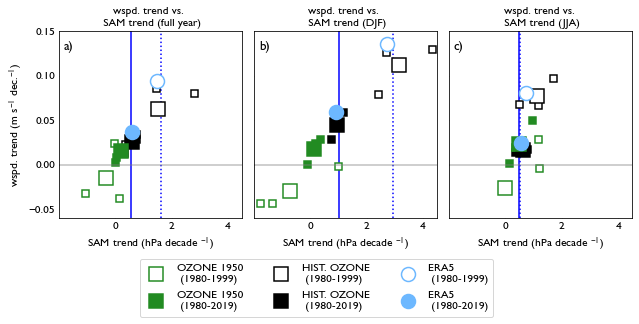

In [59]:
seas = ['FY','DJF','JJA']
    
fact = 1.4
fig, axs = plt.subplots(1,3, figsize=(6.5*fact, 2.83*fact), facecolor='w', edgecolor='k', sharey = True)
axs = axs.ravel()
    
mkz = 's'; ms = 10

ind = 0
seas = ['FY','DJF','JJA']
for s in range(0,3):
    
    ts = seas[s]
    if ts == 'full year': ts2 = 'FY'
    else: ts2 = ts
    
    obst = SAM_trend.at[ts, 'obs']
    axs[s].axvline(obst, color = 'b')
    obst = SAM_trend80.at[ts, 'obs']
    axs[s].axvline(obst, color = 'b', linestyle = ':')
    
    
    scens = [ '1B','2B', '1BM2','2BM2', '1BM3','2BM3', '1BEM', '2BEM', 'ERA5']#,'1BM2','2BM2','1BEM','2BEM']

    for sc in scens:

        mew = 1.5
        tms = 14; tmss = 7
        
        if sc == 'ERA5': mkz = 'o'; ms = tms
        elif sc == '1BEM':  ms = tms
        elif sc == '2BEM':  ms = tms
        else:
            mkz = 's'; ms = tmss
            
        #print(f'{ts}, {sc}')
        axs[s].plot(SAM_trend.at[ts,sc],wind_trend.loc[ts,sc],color = m3dict[sc]['color'], \
                     marker = mkz, markersize = ms, markeredgecolor = m3dict[sc]['color'],\
                   markeredgewidth=mew,)  

        axs[s].plot(SAM_trend80.at[ts,sc],wind_trend80.loc[ts,sc],color = 'w', \
                     marker = mkz, markersize = ms, markeredgecolor = m3dict[sc]['color'],\
                   markeredgewidth=mew,)  

im = 2
axs[im].plot(-3,0,color = 'w', markeredgecolor = 'forestgreen', markeredgewidth=mew, \
            marker = 's', markersize = tms, label = 'OZONE 1950 \n (1980-1999)', linewidth = 0)
axs[im].plot(-3,0,color = 'forestgreen', markeredgecolor = 'forestgreen', markeredgewidth=mew, \
            marker = 's', markersize = tms, label = 'OZONE 1950 \n (1980-2019)', linewidth = 0)
axs[im].plot(-3,0,color = 'w', markeredgecolor = 'k', markeredgewidth=mew, \
            marker = 's', markersize = tms, label = 'HIST. OZONE \n (1980-1999)', linewidth = 0)
axs[im].plot(-3,0,color = 'k', markeredgecolor = 'k', markeredgewidth=mew, \
            marker = 's', markersize = tms, label = 'HIST. OZONE \n (1980-2019)', linewidth = 0)
axs[im].plot(-3,0,color = 'w', markeredgecolor = '#6db8ff', markeredgewidth=mew, \
            marker = 'o', markersize = tms, label = 'ERA5 \n (1980-1999)', linewidth = 0)
axs[im].plot(-3,0,color = '#6db8ff', markeredgecolor = '#6db8ff', markeredgewidth=mew, \
            marker = 'o', markersize = tms, label = 'ERA5 \n (1980-2019)', linewidth = 0)

#axs[im].legend(ncol = 3, bbox_to_anchor = [-0.19, -0.2], prop=gill_font)

handles, labels = axs[im].get_legend_handles_labels()

# Place the legend below all three subplots
fig.legend(handles, labels, ncol=3, loc='lower center', bbox_to_anchor=(0.5, -0.15), prop=gill_font)


axs[0].set_ylabel('wspd. trend (m s$^{-1}$ dec.$^{-1})$', fontproperties=gill_font)

tits2 = ['wspd. trend vs. \n SAM trend (full year)','wspd. trend vs. \n SAM trend (DJF)','wspd. trend vs. \n SAM trend (JJA)',]
for i in range(0,3):
    
    axs[i].set_xlabel('SAM trend (hPa decade $^{-1}$)', fontproperties=gill_font)
    axs[i].set_title(tits2[i], fontproperties=gill_font)


xmi = [9.0,8.30,9.3]
for i in range(0,3):
    axs[i].set_ylim([-0.06,0.15])
    axs[i].set_xlim([-1.99,4.48])
    axs[i].axhline(y=0, color = 'grey', alpha = 0.5)

fs = 13
axs[0].text(0.025, 0.95, 'a)', transform=axs[0].transAxes,
        fontsize=fs, va='top', ha='left', fontproperties=gill_font)
axs[1].text(0.025, 0.95, 'b)', transform=axs[1].transAxes,
       fontsize=fs, va='top', ha='left', fontproperties=gill_font)
axs[2].text(0.025, 0.95, 'c)', transform=axs[2].transAxes,
        fontsize=fs, va='top', ha='left', fontproperties=gill_font)
    
axs[0].tick_params(axis='both', length=0.2, width=0.5, direction='out')
axs[1].tick_params(axis='both', length=0.2, width=0.5, direction='out')
axs[2].tick_params(axis='both', length=0.2, width=0.5, direction='out')

for label in axs[0].get_xticklabels() + axs[0].get_yticklabels():
    label.set_fontproperties(gill_font)
for label in axs[1].get_xticklabels() + axs[1].get_yticklabels():
    label.set_fontproperties(gill_font)
for label in axs[2].get_xticklabels() + axs[2].get_yticklabels():
    label.set_fontproperties(gill_font)
    
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig('./plts-gill/wind-sam-attr-all3members.jpg', bbox_inches='tight', dpi = 300)

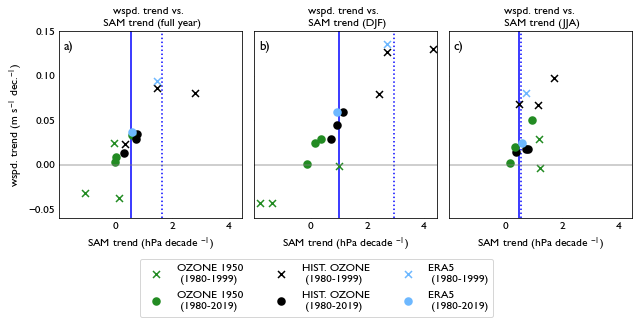

In [66]:
seas = ['FY','DJF','JJA']
    
fact = 1.4
fig, axs = plt.subplots(1,3, figsize=(6.5*fact, 2.83*fact), facecolor='w', edgecolor='k', sharey = True)
axs = axs.ravel()
    
mkz = 's'; ms = 10

ind = 0
seas = ['FY','DJF','JJA']
for s in range(0,3):
    
    ts = seas[s]
    if ts == 'full year': ts2 = 'FY'
    else: ts2 = ts
    
    obst = SAM_trend.at[ts, 'obs']
    axs[s].axvline(obst, color = 'b')
    obst = SAM_trend80.at[ts, 'obs']
    axs[s].axvline(obst, color = 'b', linestyle = ':')
    
    
    scens = [ '1B','2B', '1BM2','2BM2', '1BM3','2BM3', 'ERA5']#,'1BM2','2BM2','1BEM','2BEM']

    for sc in scens:

        mew = 1.5
        tms = 7; tmss = tms
        
        if sc == 'ERA5': mkz = 'o'; ms = tms
        elif sc == '1BEM':  ms = tms
        elif sc == '2BEM':  ms = tms
        else:
            mkz = 's'; ms = tmss
            
        #print(f'{ts}, {sc}')
        axs[s].plot(SAM_trend.at[ts,sc],wind_trend.loc[ts,sc],color = m3dict[sc]['color'], \
                     marker = 'o', markersize = ms, markeredgecolor = m3dict[sc]['color'],\
                   markeredgewidth=mew,)  

        axs[s].plot(SAM_trend80.at[ts,sc],wind_trend80.loc[ts,sc],color = 'w', \
                     marker = 'x', markersize = ms, markeredgecolor = m3dict[sc]['color'],\
                   markeredgewidth=mew,)  

im = 2
axs[im].plot(-3,0,color = 'w', markeredgecolor = 'forestgreen', markeredgewidth=mew, \
            marker = 'x', markersize = tms, label = 'OZONE 1950 \n (1980-1999)', linewidth = 0)
axs[im].plot(-3,0,color = 'forestgreen', markeredgecolor = 'forestgreen', markeredgewidth=mew, \
            marker = 'o', markersize = tms, label = 'OZONE 1950 \n (1980-2019)', linewidth = 0)
axs[im].plot(-3,0,color = 'w', markeredgecolor = 'k', markeredgewidth=mew, \
            marker = 'x', markersize = tms, label = 'HIST. OZONE \n (1980-1999)', linewidth = 0)
axs[im].plot(-3,0,color = 'k', markeredgecolor = 'k', markeredgewidth=mew, \
            marker = 'o', markersize = tms, label = 'HIST. OZONE \n (1980-2019)', linewidth = 0)
axs[im].plot(-3,0,color = 'w', markeredgecolor = '#6db8ff', markeredgewidth=mew, \
            marker = 'x', markersize = tms, label = 'ERA5 \n (1980-1999)', linewidth = 0)
axs[im].plot(-3,0,color = '#6db8ff', markeredgecolor = '#6db8ff', markeredgewidth=mew, \
            marker = 'o', markersize = tms, label = 'ERA5 \n (1980-2019)', linewidth = 0)

#axs[im].legend(ncol = 3, bbox_to_anchor = [-0.19, -0.2], prop=gill_font)

handles, labels = axs[im].get_legend_handles_labels()

# Place the legend below all three subplots
fig.legend(handles, labels, ncol=3, loc='lower center', bbox_to_anchor=(0.5, -0.15), prop=gill_font)


axs[0].set_ylabel('wspd. trend (m s$^{-1}$ dec.$^{-1})$', fontproperties=gill_font)

tits2 = ['wspd. trend vs. \n SAM trend (full year)','wspd. trend vs. \n SAM trend (DJF)','wspd. trend vs. \n SAM trend (JJA)',]
for i in range(0,3):
    
    axs[i].set_xlabel('SAM trend (hPa decade $^{-1}$)', fontproperties=gill_font)
    axs[i].set_title(tits2[i], fontproperties=gill_font)


xmi = [9.0,8.30,9.3]
for i in range(0,3):
    axs[i].set_ylim([-0.06,0.15])
    axs[i].set_xlim([-1.99,4.45])
    axs[i].axhline(y=0, color = 'grey', alpha = 0.5)

fs = 13
axs[0].text(0.025, 0.95, 'a)', transform=axs[0].transAxes,
        fontsize=fs, va='top', ha='left', fontproperties=gill_font)
axs[1].text(0.025, 0.95, 'b)', transform=axs[1].transAxes,
       fontsize=fs, va='top', ha='left', fontproperties=gill_font)
axs[2].text(0.025, 0.95, 'c)', transform=axs[2].transAxes,
        fontsize=fs, va='top', ha='left', fontproperties=gill_font)
    
axs[0].tick_params(axis='both', length=0.2, width=0.5, direction='out')
axs[1].tick_params(axis='both', length=0.2, width=0.5, direction='out')
axs[2].tick_params(axis='both', length=0.2, width=0.5, direction='out')

for label in axs[0].get_xticklabels() + axs[0].get_yticklabels():
    label.set_fontproperties(gill_font)
for label in axs[1].get_xticklabels() + axs[1].get_yticklabels():
    label.set_fontproperties(gill_font)
for label in axs[2].get_xticklabels() + axs[2].get_yticklabels():
    label.set_fontproperties(gill_font)
    
plt.tight_layout(rect=[0, 0.05, 1, 1])
#plt.savefig('./plts-gill/wind-sam-attr-all3members.jpg', bbox_inches='tight')